In [1]:
import pandas as pd

## Linear Regression

In [2]:
df = pd.read_csv("../Data/survival_episodes_cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7271 entries, 0 to 7270
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   randid                    7271 non-null   object 
 1   start_date                7271 non-null   object 
 2   duration                  7271 non-null   int64  
 3   event_observed            7271 non-null   int64  
 4   NOAAClimRegion            7271 non-null   object 
 5   TempZone                  7271 non-null   object 
 6   HumidZone                 7271 non-null   object 
 7   bin_PlantSize_kW          7271 non-null   object 
 8   plant_age_months          7271 non-null   float64
 9   active_snow_tickets       7271 non-null   object 
 10  snow_bin_ticket_minutes   426 non-null    object 
 11  snow_affected_assets      426 non-null    object 
 12  snow_production_level     7271 non-null   object 
 13  snow_value_mm             7271 non-null   float64
 14  total_da

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Ensure 'Date' column is in datetime format
df['start_date'] = pd.to_datetime(df['start_date'])

# Extract time-based features from 'Date'
df['year'] = df['start_date'].dt.year
df['month'] = df['start_date'].dt.month
df['day_of_week'] = df['start_date'].dt.dayofweek
df['day_of_year'] = df['start_date'].dt.dayofyear
df['hour'] = df['start_date'].dt.hour

# Drop original 'Date' and 'randid' as they are not direct features for the model
# Assuming 'randid' exists; if not, remove it from this line.
if 'randid' in df.columns:
    df = df.drop(['start_date', 'randid'], axis=1)
else:
    df = df.drop(['start_date'], axis=1)


# Identify numerical and categorical features
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

# Remove the target variable from numerical features list
if 'duration' in numerical_features:
    numerical_features.remove('duration')

print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")
print("\n")

Numerical Features: ['event_observed', 'plant_age_months', 'snow_value_mm', 'total_daily_snow_mm', 'low_irradiation', 'cumulative_snow_mm', 'hurricane', 'nearest_hurricane', 'wind_speed_mean', 'rain_value_mm', 'nearest_rain', 'lightning', 'storm', 'duration_minutes_storm', 'nearest_storm', 'flood', 'duration_minutes_flood', 'nearest_flood', 'rain', 'weather_onset', 'year', 'month', 'day_of_week', 'day_of_year', 'hour']
Categorical Features: ['NOAAClimRegion', 'TempZone', 'HumidZone', 'bin_PlantSize_kW', 'active_snow_tickets', 'snow_bin_ticket_minutes', 'snow_affected_assets', 'snow_production_level', 'hurr_bin_ticket_minutes', 'hurr_affected_assets', 'hurr_production_level', 'HurricanePrep', 'HurricanePostInspection', 'storm_active_tickets', 'storm_bin_ticket_minutes', 'storm_affected_assets', 'storm_production_level']




In [8]:
# --- 3. Advanced Feature Selection ---

# 3.2 Remove features with too many missing values (e.g., > 80%)
initial_features = numerical_features + categorical_features
features_to_drop_high_missing = []
for col in initial_features:
    if df[col].isnull().sum() / len(df) > 0.8: # Threshold for high missingness
        features_to_drop_high_missing.append(col)
        print(f"Dropping '{col}' due to high missing value percentage.")

df = df.drop(columns=features_to_drop_high_missing)
df_original = df.copy()
numerical_features = [f for f in numerical_features if f not in features_to_drop_high_missing]
categorical_features = [f for f in categorical_features if f not in features_to_drop_high_missing]


# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a preprocessor that applies transformations to different column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (like PC2, PC3 if not explicitly handled)
)

# Split data into training and testing sets

X = df.drop('duration', axis=1)
y = df['duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Apply preprocessing to training data to get transformed feature names
X_train_processed = preprocessor.fit_transform(X_train)
# Get feature names after one-hot encoding
# Ensure 'categorical_features' is not empty before calling get_feature_names_out
if categorical_features:
    ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
else:
    ohe_feature_names = [] # No categorical features to get names from

all_transformed_features = numerical_features + list(ohe_feature_names)

# Convert processed data back to DataFrame for feature selection steps
# Handle cases where all_transformed_features might be empty if no features are left
if not all_transformed_features:
    raise ValueError("No features remaining after initial preprocessing and missing value handling. Please check your data.")

X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_transformed_features, index=X_train.index)
X_test_processed = preprocessor.transform(X_test)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_transformed_features, index=X_test.index)


# 3.3 Variance Threshold (after imputation and scaling)
# Remove features with low variance (e.g., constant features)
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01) # Remove features with variance less than 0.01
X_train_vt = selector.fit_transform(X_train_processed_df)
selected_features_vt = X_train_processed_df.columns[selector.get_support()]
print(f"Features after Variance Threshold: {len(selected_features_vt)} features selected.")
X_train_processed_df = X_train_processed_df[selected_features_vt]
X_test_processed_df = X_test_processed_df[selected_features_vt]

if X_train_processed_df.empty:
    raise ValueError("No features remaining after Variance Threshold. Adjust threshold or check data.")


# 3.4 SelectKBest (Univariate Feature Selection)
# Select top K features based on ANOVA F-value (suitable for classification target)
# Ensure k is not greater than the number of available features
k_to_select = min(20, X_train_processed_df.shape[1])
k_best_selector = SelectKBest(f_classif, k=k_to_select)
X_train_kbest = k_best_selector.fit_transform(X_train_processed_df, y_train)
selected_features_kbest = X_train_processed_df.columns[k_best_selector.get_support()]
print(f"Features after SelectKBest: {len(selected_features_kbest)} features selected.")
X_train_processed_df = X_train_processed_df[selected_features_kbest]
X_test_processed_df = X_test_processed_df[selected_features_kbest]

if X_train_processed_df.empty:
    raise ValueError("No features remaining after SelectKBest. Adjust k or check data.")

# 3.5 Lasso Regression for Feature Selection (L1 Regularization)
# Lasso can shrink coefficients of less important features to zero, effectively selecting features.
# We'll use LassoCV to find the optimal alpha (regularization strength).
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_processed_df, y_train)

# Get features with non-zero coefficients
selected_features_lasso = X_train_processed_df.columns[lasso.coef_ != 0]
print(f"Features after Lasso Regression: {len(selected_features_lasso)} features selected.")

if len(selected_features_lasso) == 0:
    raise ValueError("Lasso Regression selected no features. Consider adjusting Lasso parameters or feature scaling.")

X_train_final = X_train_processed_df[selected_features_lasso]
X_test_final = X_test_processed_df[selected_features_lasso]


# 3.6 Recursive Feature Elimination (RFE)
# RFE works by recursively fitting a model and eliminating the worst or least important feature.
# We'll use LinearRegression as the base estimator.
# Note: RFE can be computationally intensive with many features.
# We will apply RFE on the features already selected by Lasso for efficiency.
estimator = LinearRegression()
# Ensure n_features_to_select is not greater than the number of features available after Lasso
n_features_rfe = min(10, X_train_final.shape[1])
if n_features_rfe == 0:
    raise ValueError("No features available for RFE after Lasso. Check previous feature selection steps.")

rfe_selector = RFE(estimator=estimator, n_features_to_select=n_features_rfe, step=1)
rfe_selector.fit(X_train_final, y_train)
selected_features_rfe = X_train_final.columns[rfe_selector.get_support()]
print(f"Features after RFE: {len(selected_features_rfe)} features selected.")

# Final set of features to use for the model
if len(selected_features_rfe) == 0:
    raise ValueError("RFE selected no features. Consider adjusting RFE parameters or previous feature selection steps.")

X_train_model = X_train_final[selected_features_rfe]
X_test_model = X_test_final[selected_features_rfe]

print("\nFinal Features selected for the Linear Regression Model:")
print(selected_features_rfe.tolist())


Features after Variance Threshold: 51 features selected.
Features after SelectKBest: 20 features selected.
Features after Lasso Regression: 17 features selected.
Features after RFE: 10 features selected.

Final Features selected for the Linear Regression Model:
['event_observed', 'lightning', 'year', 'month', 'day_of_year', 'NOAAClimRegion_Northeast', 'NOAAClimRegion_Southwest', 'NOAAClimRegion_Upper Midwest', 'TempZone_T7', 'storm_production_level_Partial']


In [9]:
# --- 4. Model Training ---
print("\nTraining Linear Regression Model...")
linear_model = LinearRegression()
linear_model.fit(X_train_model, y_train)
print("Model training complete.")

# --- 5. Evaluation ---
y_pred_train = linear_model.predict(X_train_model)
y_pred_test = linear_model.predict(X_test_model)

# Evaluate on training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\n--- Model Evaluation on Training Set ---")
print(f"Root Mean Squared Error (RMSE): {rmse_train:.4f}")
print(f"Mean Absolute Error (MAE): {mae_train:.4f}")
print(f"R-squared (R2): {r2_train:.4f}")

# Evaluate on test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("\n--- Model Evaluation on Test Set ---")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"R-squared (R2): {r2_test:.4f}")

# Display model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(X_train_model.columns, linear_model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {linear_model.intercept_:.4f}")


Training Linear Regression Model...
Model training complete.

--- Model Evaluation on Training Set ---
Root Mean Squared Error (RMSE): 34.2049
Mean Absolute Error (MAE): 26.7964
R-squared (R2): 0.6137

--- Model Evaluation on Test Set ---
Root Mean Squared Error (RMSE): 33.5154
Mean Absolute Error (MAE): 26.1156
R-squared (R2): 0.5993

Model Coefficients:
event_observed: -30.8289
lightning: 14.6797
year: -75.9111
month: -9.8306
day_of_year: -45.9993
NOAAClimRegion_Northeast: 4.0987
NOAAClimRegion_Southwest: 12.4933
NOAAClimRegion_Upper Midwest: 21.7002
TempZone_T7: 23.4296
storm_production_level_Partial: -49.7437
Intercept: 34.5719



--- Interpreting Power Outage Duration Predictions ---
The model predicts 'duration', which is a continuous numerical variable.
The output values directly represent the predicted duration of a power outage.

--- Regression Metrics ---
Mean Absolute Error (MAE): 26.1156
Mean Squared Error (MSE): 1123.2812
Root Mean Squared Error (RMSE): 33.5154
R-squared (R2): 0.5993


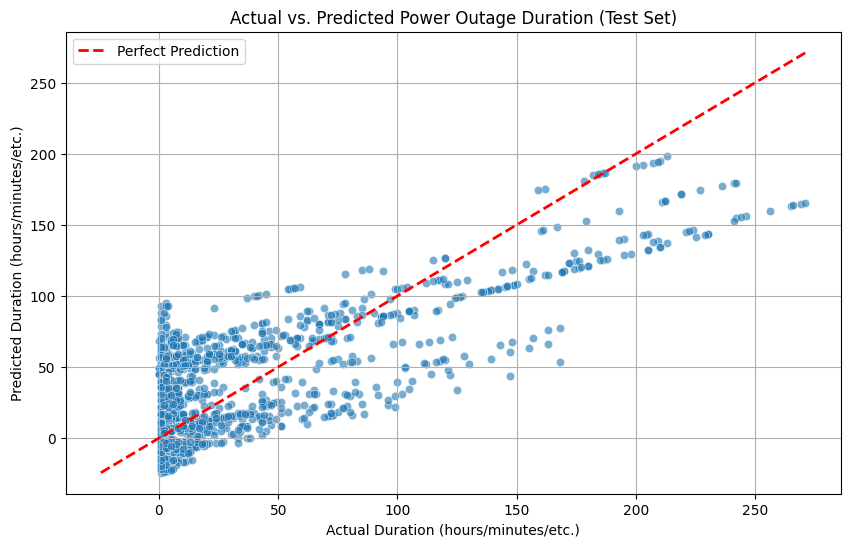

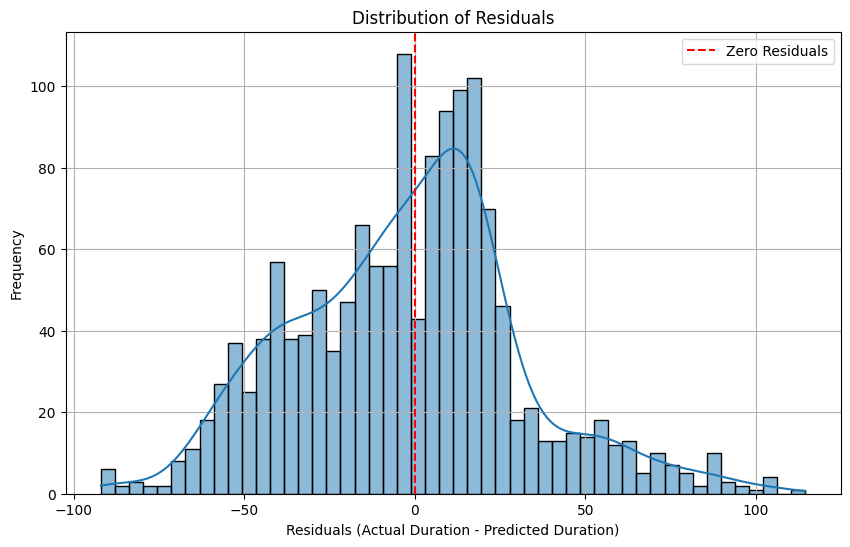

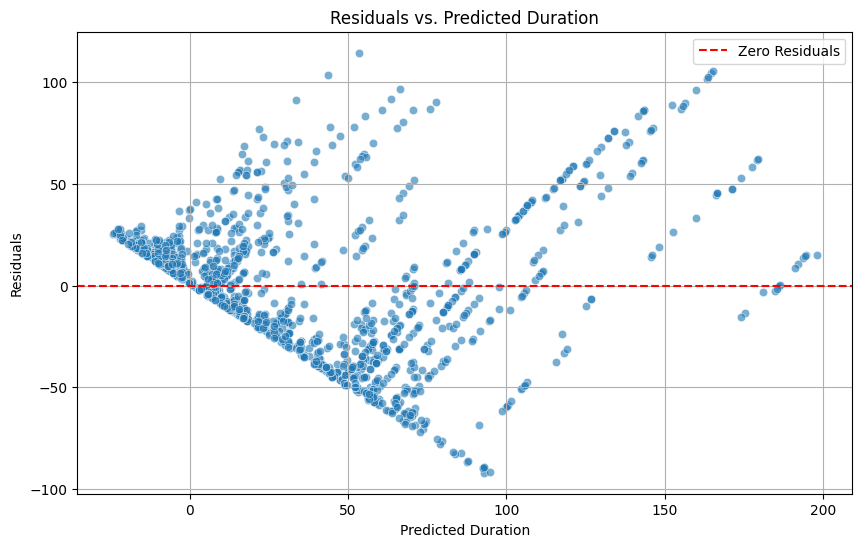

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming y_pred_test contains your model's predictions and y_test contains the actual 'duration' values

# --- Interpretation of Results for Power Outage Duration Prediction ---
print("\n--- Interpreting Power Outage Duration Predictions ---")
print("The model predicts 'duration', which is a continuous numerical variable.")
print("The output values directly represent the predicted duration of a power outage.")

# --- Regression Metrics ---
print("\n--- Regression Metrics ---")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"R-squared (R2): {r2_score(y_test, y_pred_test):.4f}")

# --- Visualizations for Regression ---

# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)
# Add a perfect prediction line (y=x)
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Duration (hours/minutes/etc.)")
plt.ylabel("Predicted Duration (hours/minutes/etc.)")
plt.title("Actual vs. Predicted Power Outage Duration (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the distribution of residuals
# Residuals = Actual - Predicted
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Residuals')
plt.xlabel("Residuals (Actual Duration - Predicted Duration)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.legend()
plt.grid(True)
plt.show()

# Residuals vs. Predicted values (to check for heteroscedasticity)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residuals')
plt.xlabel("Predicted Duration")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Duration")
plt.legend()
plt.grid(True)
plt.show()